# Part 2 Assignment: Classification Model

### Import Libraries & Load Data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv('CE802_P2_Data.csv')

## Data Summary Statistics

In [7]:
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,16,6.03,-4.56,30.00,63.04,0.55,-0.78,0.96,-1.67,1,-339.75,0.84,9.90,-2.22,-9.53,False
1,6,1.41,-4.24,31.38,100.04,0.06,1.08,0.60,-3.67,1,-246.75,-0.62,12.32,-0.56,NaN,False
2,630,43.35,0.50,50.70,219.04,-3.46,10.08,5.65,-14.67,10,-129.75,-3.40,1.80,8.48,-10.29,False
3,30,2.79,-3.58,31.83,69.04,-0.40,-0.09,0.18,-1.67,1,-276.75,-0.32,13.32,1.36,-9.92,False
4,18,0.36,-6.62,32.97,75.04,2.43,0.24,0.48,-0.67,1,-294.75,3.14,10.80,-5.86,NaN,True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      1500 non-null   int64  
 1   F2      1500 non-null   float64
 2   F3      1500 non-null   float64
 3   F4      1500 non-null   float64
 4   F5      1500 non-null   float64
 5   F6      1500 non-null   float64
 6   F7      1500 non-null   float64
 7   F8      1500 non-null   float64
 8   F9      1500 non-null   float64
 9   F10     1500 non-null   int64  
 10  F11     1500 non-null   float64
 11  F12     1500 non-null   float64
 12  F13     1500 non-null   float64
 13  F14     1500 non-null   float64
 14  F15     750 non-null    float64
 15  Class   1500 non-null   bool   
dtypes: bool(1), float64(13), int64(2)
memory usage: 177.4 KB



*   All features are either 'float' or 'int'
*   F15 contains 50% missing values



In [9]:
df.describe()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15
count,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,750.000000
mean,218.049333,14.90628,-0.829733,41.063440,133.485333,-1.592947,5.390220,3.854280,-7.308000,5.403333,-307.992000,0.244707,7.315067,3.542427,-10.463013
std,234.669160,12.97563,5.090345,9.500727,71.416874,2.513850,7.662813,3.465276,7.159315,4.504907,120.565344,2.217929,4.982472,5.081288,1.005117
min,0.000000,0.00000,-17.560000,30.000000,54.040000,-6.070000,-19.800000,0.000000,-24.670000,0.000000,-609.750000,-4.480000,-1.700000,-14.520000,-12.820000
25%,30.000000,3.72000,-4.600000,32.160000,78.040000,-4.000000,-0.300000,0.600000,-14.670000,1.000000,-354.750000,-1.060000,2.560000,-0.220000,-11.210000
50%,100.000000,6.21000,-2.810000,33.240000,98.040000,-0.610000,2.400000,1.020000,-3.670000,1.000000,-291.750000,-0.060000,9.220000,1.580000,-10.470000
75%,390.000000,24.60000,4.080000,49.350000,194.040000,0.350000,12.877500,7.050000,-1.670000,10.000000,-252.750000,1.400000,10.985000,8.500000,-9.742500
max,780.000000,47.10000,8.300000,60.450000,299.040000,6.070000,18.810000,10.350000,1.330000,10.000000,35.250000,8.720000,22.780000,12.860000,-7.740000


*   Data has very different ranges so will need to be scaled



<AxesSubplot:xlabel='Class', ylabel='count'>

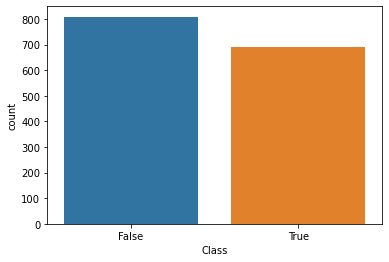

In [10]:
sns.countplot(x="Class", data=df)

## Data Modelling

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [12]:
X = df.drop(['Class'], axis=1)
y = df['Class']

In [13]:
# initiate scaler
scaler = StandardScaler()

# create dictionary of imputation methods
imputation_methods = {
                      "const": SimpleImputer(strategy='constant', fill_value = 0, missing_values=np.nan), 
                      "mean": SimpleImputer(strategy='mean', missing_values=np.nan), 
                      "knn": KNNImputer(missing_values=np.nan),
                      "iter": IterativeImputer(missing_values=np.nan, random_state = 0) 
}

# create cross validation splits using KFold
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)


### Create Parameter Space

In [14]:
# create paramater space per model
param_grid_tree = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features' : [None, 'auto', 'sqrt', 'log2']
}

param_grid_forest = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features' : ['auto', 'sqrt', 'log2']
}

param_grid_reg = {
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

param_grid_knn = {
    'classifier__n_neighbors': [1,3,5,7,10,15,20],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__weights' : ['uniform', 'distance']
}

param_grid_svm = {
    'classifier__kernel': ['poly', 'rbf', 'sigmoid'],
    'classifier__C': [0.01, 1, 5, 10, 100]
}

# create dictionary of classifiers with the classifier and paramaters as value 
classifiers = {
              "tree": (DecisionTreeClassifier(), param_grid_tree),
              "forest": (RandomForestClassifier(), param_grid_forest),
               "reg": (LogisticRegression(), param_grid_reg),
               'knn': (KNeighborsClassifier(), param_grid_knn),
               'svm': (SVC(), param_grid_svm)
}


In [15]:
# empty dictionary to store each model pipeline and respective params as values
models_params = {}

# loop over to fill dictionary
for classifier_name, classifier in classifiers.items():
  for method_name, method in imputation_methods.items():
    pipe = Pipeline(steps=[('imputer', method),
                           ('scaler', scaler),
                           ('classifier', classifier[0])])
    models_params[f"{classifier_name}_{method_name}"] = (pipe, classifier[1])

In [16]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

# variables initiated for classification report
originalclass = []
predictedclass = []

# define custom scoring function
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

### Finding the Best Model

In [17]:
avg_outer_score = dict()

for name, (pipe, params) in models_params.items():
    originalclass = []
    predictedclass = []
    # compute nested cross validation using GridSearchCV to find the optimal model for that pipeline
    optimised_model = GridSearchCV(pipe, params, cv=inner_cv, scoring='accuracy')
    scores = cross_val_score(optimised_model, X, y, cv=outer_cv, scoring=make_scorer(classification_report_with_accuracy_score))
    # get the average of the outer fold scores
    avg_outer_score[name] = np.mean(scores)
    rounded_scores = [f"{score:.2f}" for score in scores] #rounded scores for print statement
    print(f"{name}\nAccuracy in the outer folds: {rounded_scores}.\nAverage Error: {np.mean(scores):.2f}")
    print()
    print(classification_report(originalclass, predictedclass)) 


tree_const
Accuracy in the outer folds: ['0.81', '0.77', '0.79', '0.77', '0.81'].
Average Error: 0.79

              precision    recall  f1-score   support

       False       0.80      0.82      0.81       809
        True       0.78      0.76      0.77       691

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500

tree_mean
Accuracy in the outer folds: ['0.79', '0.80', '0.82', '0.77', '0.78'].
Average Error: 0.79

              precision    recall  f1-score   support

       False       0.80      0.81      0.81       809
        True       0.78      0.77      0.77       691

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500

tree_knn
Accuracy in the outer folds: ['0.75', '0.76', '0.75', '0.78', '0.76'].
Average Error: 0.76

              precision    recall  f1-sc

C:\Users\carte\miniconda3\envs\ce889\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\carte\miniconda3\envs\ce889\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\carte\miniconda3\envs\ce889\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\carte\miniconda3\envs\ce889\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\carte\miniconda3\envs\ce889\lib\site-packages\sklearn\linear_model\_sag.py:

reg_iter
Accuracy in the outer folds: ['0.89', '0.84', '0.86', '0.85', '0.85'].
Average Error: 0.86

              precision    recall  f1-score   support

       False       0.88      0.86      0.87       809
        True       0.84      0.86      0.85       691

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500

knn_const
Accuracy in the outer folds: ['0.75', '0.75', '0.78', '0.75', '0.79'].
Average Error: 0.76

              precision    recall  f1-score   support

       False       0.76      0.83      0.79       809
        True       0.78      0.68      0.73       691

    accuracy                           0.76      1500
   macro avg       0.77      0.76      0.76      1500
weighted avg       0.76      0.76      0.76      1500

knn_mean
Accuracy in the outer folds: ['0.78', '0.80', '0.81', '0.81', '0.81'].
Average Error: 0.80

              precision    recall  f1-scor

In [18]:
# store best model, associated parameters and score
best_model, best_model_score = max(avg_outer_score.items(),key=(lambda name_averagescore: name_averagescore[1]))
best_model, best_model_params = models_params[name]

print(f"The best model is:\n{best_model} \nWith an average score of: {best_model_score}")

The best model is:
Pipeline(steps=[('imputer', IterativeImputer(random_state=0)),
                ('scaler', StandardScaler()), ('classifier', SVC())]) 
With an average score of: 0.8886666666666667


## Applying to the Test Set

In [19]:
test_df = pd.read_csv("CE802_P2_Test.csv")

In [20]:
test_inputs_df = test_df.drop(['Class'], axis = 1)

In [21]:
# fit our best model to the entire data set
best_model.fit(X,y)
y_pred = best_model.predict(test_inputs_df)

In [22]:
# check value counts to see distribution
y_pred = pd.Series(y_pred)
y_pred.value_counts() 

False    802
True     698
dtype: int64

In [23]:
# add our predictions back to test dataframe
test_df['Class'] = y_pred
test_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,4,5.58,-4.66,31.83,69.04,-0.35,-1.29,0.06,-3.67,1,-243.75,0.94,13.84,-1.48,-11.04,True
1,80,37.95,4.40,50.70,199.04,-4.83,5.19,7.25,-4.67,10,-474.75,-3.34,0.46,8.72,NaN,True
2,60,1.08,-4.14,32.13,73.04,0.14,2.01,0.59,-3.67,1,-234.75,-1.08,9.36,-1.20,-11.71,True
3,240,34.95,3.74,44.85,264.04,-2.92,11.52,8.45,-14.67,10,-174.75,-3.20,2.94,4.14,-10.40,False
4,42,4.11,-3.78,31.92,92.04,1.09,-2.67,0.72,-3.67,1,-282.75,-0.40,11.20,0.92,-11.14,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,62,5.13,-5.32,32.46,72.04,1.17,-1.62,0.41,0.33,1,-306.75,1.20,9.24,0.96,NaN,True
1496,30,0.69,-3.96,32.70,78.04,-0.16,-0.57,0.01,-1.67,1,-288.75,1.48,9.68,-0.08,NaN,True
1497,94,4.95,-5.38,32.19,91.04,1.99,1.47,0.56,-1.67,1,-252.75,-0.86,12.04,-0.28,NaN,True
1498,70,3.72,-6.82,33.06,74.04,0.50,2.52,0.24,0.33,1,-351.75,-0.08,9.48,0.34,NaN,True


In [24]:
# export to csv
test_df.to_csv('CE802_P2_Results.csv', index=False)